In [1]:
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader
import torch
from torch import nn
from torch import optim

In [2]:
import os
import numpy as np

from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib import ticker, cm
from matplotlib import gridspec

In [3]:
from DeepGenerativeModels.AutoEncoders import VAE, IWAE

In [4]:
import utils

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
data = MNIST('mnist', download=True, train=True)
train_data = TensorDataset(data.train_data.view(-1, 28 * 28).float() / 255, data.train_labels)
data = MNIST('mnist', download=True, train=False)
test_data = TensorDataset(data.test_data.view(-1, 28 * 28).float() / 255, data.test_labels)

# Обучение

## VAE

In [7]:
model_vae = VAE(2, 28*28, device=device)

In [8]:
optimizer = optim.Adam(model_vae.parameters(), lr=0.001)

In [9]:
# utils.trainer(model = model_vae, 
#         optimizer = optimizer, 
#         dataset = train_data, 
#         count_of_epoch = 40,
#         batch_size = 64,
#         callback = None,
#         progress = tqdm)

In [10]:
# torch.save(model_vae.state_dict(), './models/vae_d_2.model')
# files.download('./models/vae_d_2.model')

In [11]:
model_vae.load_state_dict(torch.load('./models/vae_d_2.model', map_location=device))

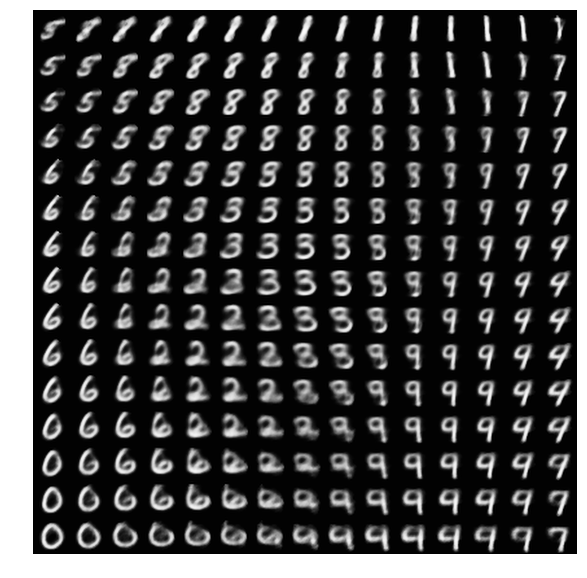

In [12]:
figure = utils.draw_samples_grid_vae(model_vae)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
plt.axis('off')
plt.show()

## IWAE

In [13]:
model_iwae = IWAE(2, 28*28, K = 50, device=device)

In [14]:
optimizer = optim.Adam(model_iwae.parameters(), lr=0.001)

In [15]:
# utils.trainer(model = model_iwae, 
#                 optimizer = optimizer, 
#                 dataset = train_data,
#                 count_of_epoch = 40,
#                 batch_size = 64,
#                 callback = None,
#                 progress = tqdm)

In [16]:
# torch.save(model_iwae.state_dict(), './models/iwae_d_2_k_50.model')
# files.download('./models/iwae_d_2_k_50.model')

In [17]:
model_iwae.load_state_dict(torch.load('./models/iwae_d_2_k_50.model', map_location=device))

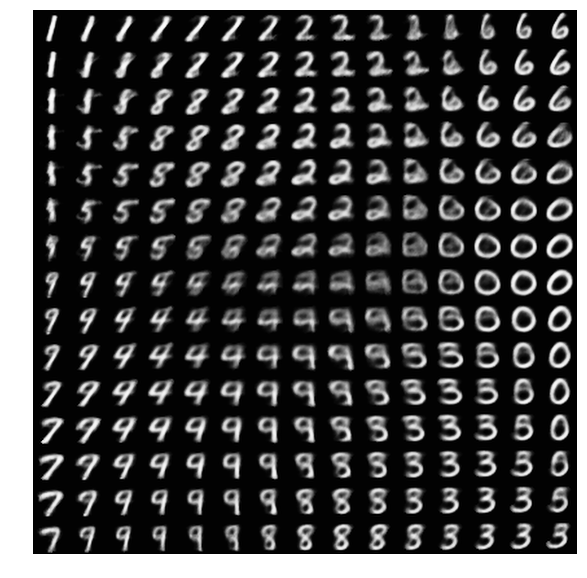

In [18]:
figure = utils.draw_samples_grid_vae(model_iwae)

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
plt.axis('off')
plt.show()

# Simple Comparasion
We will look at our autoencoders through mse and loss function.
While mse can show which model is better for restoring the image, loss function $\mathcal{L}_K$ can show how clear the generated images are.

In this part of experimet we are using $q(z|x)$ distribution for generation samples in latent space for both model.


In [19]:
batch_x, batch_y = list(DataLoader(test_data, batch_size = len(train_data)))[0]
batch_x = batch_x.to(device)
batch_y = batch_y.to(device)

In [20]:
vae_mse, vae_loss = utils.score_ae(model_vae, batch_x, batch_y)
iwae_mse, iwae_loss = utils.score_ae(model_iwae, batch_x, batch_y)

In [22]:
data = dict()
data['VAE'] = [vae_mse, vae_loss]
data['IWAE'] = [iwae_mse, iwae_loss]

print(utils.draw_table(data, title = ['MSE', 'Model Loss']))

|--------------------||--------------------||--------------------|
|                    ||                 MSE||          Model Loss|
|--------------------||--------------------||--------------------|
|                 VAE||  0.0406000018119812||           153.29706|
|--------------------||--------------------||--------------------|
|                IWAE||0.055890001356601715||           146.04306|
|--------------------||--------------------||--------------------|



# Digits Reconstruction

In [22]:
batch_x, batch_y = list(DataLoader(test_data, batch_size = 5))[2]
batch_x = batch_x.to(device)
batch_y = batch_y.to(device)

## VAE

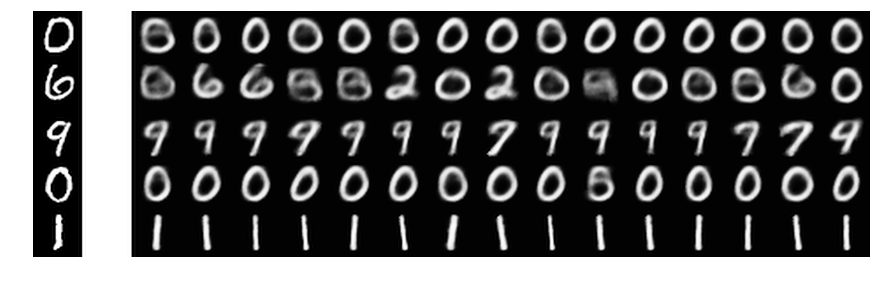

In [23]:
figure = utils.draw_reconstucted_samples(model_iwae, batch_x, IW_sampler = False)


plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
plt.axis('off')
plt.show()

## IWAE

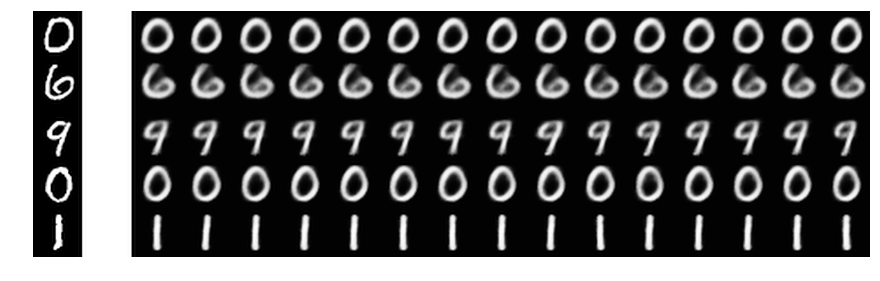

In [24]:
figure = utils.draw_reconstucted_samples(model_iwae, batch_x, IW_sampler = True)


plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
plt.axis('off')
plt.show()

# Posterior Visualisations

In [25]:
# Real distribution
mixture = [multivariate_normal(mean=3*np.array([0, 1]), cov=2*np.eye(2)), 
           multivariate_normal(mean=-1.5*np.ones(2), cov=0.75*np.eye(2)), 
           multivariate_normal(mean=1.5*np.ones(2), cov=np.eye(2)), 
           multivariate_normal(mean=np.zeros(2), cov=np.eye(2)), 
           multivariate_normal(mean=3*np.array([0, 1]), cov=np.eye(2))]
p_z = lambda x: np.log(np.mean(np.array([mix.pdf(x) for mix in mixture]), axis = 0))


In [26]:
images_size = (200, 200)
list_of_K = [1, 10, 30, 60, 100, 150, 200]
list_of_image = []

x = np.linspace(-5, 5, images_size[0])
y = np.linspace(-4, 6, images_size[1])
xx, yy = np.meshgrid(x, y)


# Real Posterior
probas = np.zeros(xx.shape)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        z = np.array([xx[i,j], yy[i,j]]).reshape([1, -1])
        probas[i, j] = np.exp(p_z(z))
list_of_image.append(probas)

# Approzimated posterior
for k in tqdm(list_of_K):
    probas = np.zeros(xx.shape)
    for i in range(xx.shape[0]):
        for j in range(xx.shape[1]):
            z = np.array([xx[i,j], yy[i,j]]).reshape([1, -1])
            probas[i, j] = utils.q_IW(z, K=k)
    list_of_image.append(probas)

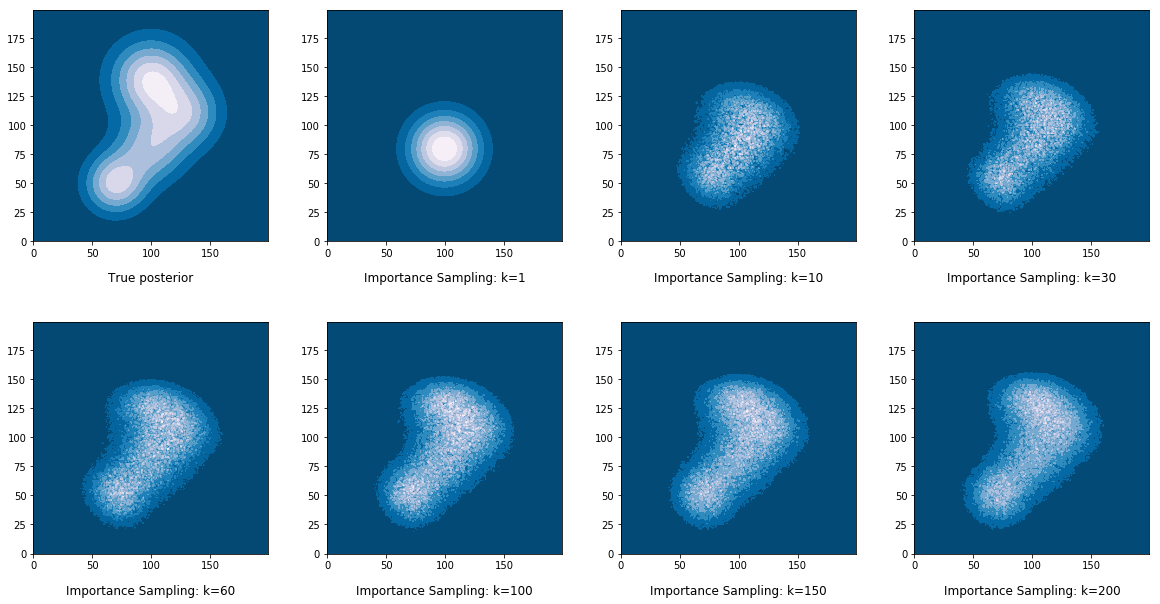

In [27]:
num_row = 2
num_col = 4

plt.rcParams['figure.figsize'] = (num_col*5.0, num_row*5.0)

fig = plt.figure()
gs = gridspec.GridSpec(num_row, num_col)
ax = []
for i in range(gs.get_geometry()[0]):
    for j in range(gs.get_geometry()[1]):
        ax.append(fig.add_subplot(gs[i, j]))
    
for i, image in enumerate(list_of_image):
    ax[i].contourf(image, cmap=cm.PuBu_r)
    if i == 0:
        ax[i].set_title('True posterior', y=-0.2)
    else:
        ax[i].set_title('Importance Sampling: k={}'.format(list_of_K[i-1]), y=-0.2)

plt.subplots_adjust(wspace=0.25, hspace=0.35)
        
plt.show()